In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Segmentation

In [1]:
import os
import numpy as np
from PIL import Image
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Cropping2D, BatchNormalization, Multiply, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


ModuleNotFoundError: No module named 'sklearn'

In [3]:

# Function to extract numeric value for sorting
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Function to crop the center of an image
def crop_center(image, crop_width, crop_height):
    h, w = image.shape
    start_x = (w - crop_width) // 2
    start_y = (h - crop_height) // 2
    return image[start_y:start_y + crop_height, start_x:start_x + crop_width]

# Function to apply thresholding to masks
def apply_threshold(mask, threshold=128):
    return (mask > threshold).astype(np.uint8)

# Function to load images and masks
def load_data(dataset_path, crop_size=(128, 128), threshold=128):  # Default crop size is 128x128
    images = []
    masks = []
    image_paths = []  # List to store the paths of the images
    mask_paths = []   # List to store the paths of the masks

    for patient in os.listdir(dataset_path):
        patient_folder = os.path.join(dataset_path, patient)

        if os.path.isdir(patient_folder):
            mask_folder = os.path.join(patient_folder, 'Mask')
            original_folder = os.path.join(patient_folder, 'Original')

            # Get and sort the mask and original images
            mask_images = sorted(os.listdir(mask_folder), key=extract_number)
            original_images = sorted(os.listdir(original_folder), key=extract_number)

            for mask_name, original_name in zip(mask_images, original_images):
                try:
                    # Construct paths
                    mask_path = os.path.join(mask_folder, mask_name)
                    original_path = os.path.join(original_folder, original_name)

                    # Load and preprocess the mask
                    mask_image = Image.open(mask_path).convert('L')
                    mask_image = mask_image.resize((256, 256))  # Resize to desired shape
                    mask_array = np.array(mask_image)

                    # Apply thresholding and crop the center of the mask
                    binary_mask = apply_threshold(mask_array, threshold)
                    cropped_mask = crop_center(binary_mask, crop_size[0], crop_size[1])
                    masks.append(cropped_mask)
                    mask_paths.append(mask_path)  # Store the mask path

                    # Load and preprocess the original image (JPG format)
                    original_image = Image.open(original_path).convert('L')
                    original_image = original_image.resize((256, 256))  # Resize to desired shape
                    original_array = np.array(original_image)

                    # Crop the center of the original image
                    cropped_image = crop_center(original_array, crop_size[0], crop_size[1])
                    images.append(cropped_image)
                    image_paths.append(original_path)  # Store the original image path

                    # Print the patient ID and corresponding image paths
                    print(f"Patient ID: {patient} | Original Image Path: {original_path} | Mask Path: {mask_path}")

                except Exception as e:
                    print(f"Error loading {mask_name} or {original_name}: {e}")

    return np.array(images), np.array(masks), image_paths, mask_paths




In [ ]:
# Path to dataset folder
dataset_path = "/content/drive/MyDrive/Mensicus_project/original_mask"
images, masks, image_paths, mask_paths = load_data(dataset_path, crop_size=(128, 128), threshold=128)  # Use a 128x128 crop size

# Calculate mean and standard deviation for the entire dataset
mean = np.mean(images, axis=(1, 2), keepdims=True)
std = np.std(images, axis=(1, 2), keepdims=True)

# Apply standardization (Z-score normalization)
standardized_images = (images - mean) / std



Patient ID: Pat 96 | Original Image Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Original/00001_8f3e9ade636c6a94.jpg | Mask Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Mask/image.1.jpg
Patient ID: Pat 96 | Original Image Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Original/00002_bc70e6e76b7fe0a7.jpg | Mask Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Mask/image.2.jpg
Patient ID: Pat 96 | Original Image Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Original/00003_4f399bae7b3df254.jpg | Mask Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Mask/image.3.jpg
Patient ID: Pat 96 | Original Image Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Original/00004_4d5868723dc143bf.jpg | Mask Path: /content/drive/MyDrive/Mensicus_project/original_mask/Pat 96/Mask/image.4.jpg
Patient ID: Pat 96 | Original Image Path: /content/drive/MyDrive/Mensicus_projec

In [ ]:

# Shuffle the dataset (images and masks together to maintain correspondence)
standardized_images, masks = shuffle(standardized_images, masks, random_state=42)


# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(standardized_images, masks, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training image shape: {X_train.shape}")
print(f"Validation image shape: {X_val.shape}")
print(f"Test image shape: {X_test.shape}")
print(f"Training mask shape: {y_train.shape}")
print(f"Validation mask shape: {y_val.shape}")
print(f"Test mask shape: {y_test.shape}")


Training image shape: (991, 128, 128)
Validation image shape: (462, 128, 128)
Test image shape: (199, 128, 128)
Training mask shape: (991, 128, 128)
Validation mask shape: (462, 128, 128)
Test mask shape: (199, 128, 128)


In [ ]:

# Save the datasets to pickle files
with open('/content/drive/MyDrive/Mensicus_project/X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

with open('/content/drive/MyDrive/Mensicus_project/X_val.pkl', 'wb') as file:
    pickle.dump(X_val, file)

with open('/content/drive/MyDrive/Mensicus_project/X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

with open('/content/drive/MyDrive/Mensicus_project/y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('/content/drive/MyDrive/Mensicus_project/y_val.pkl', 'wb') as file:
    pickle.dump(y_val, file)

with open('/content/drive/MyDrive/Mensicus_project/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

print("Datasets have been saved in pickle format.")


Datasets have been saved in pickle format.


In [ ]:
import pickle
# Load datasets from pickle files
with open('/content/drive/MyDrive/Mensicus_project/X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('/content/drive/MyDrive/Mensicus_project/X_val.pkl', 'rb') as file:
    X_val = pickle.load(file)

with open('/content/drive/MyDrive/Mensicus_project/X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('/content/drive/MyDrive/Mensicus_project/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('/content/drive/MyDrive/Mensicus_project/y_val.pkl', 'rb') as file:
    y_val = pickle.load(file)

with open('/content/drive/MyDrive/Mensicus_project/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

print("Datasets have been loaded from pickle files.")


Datasets have been loaded from pickle files.


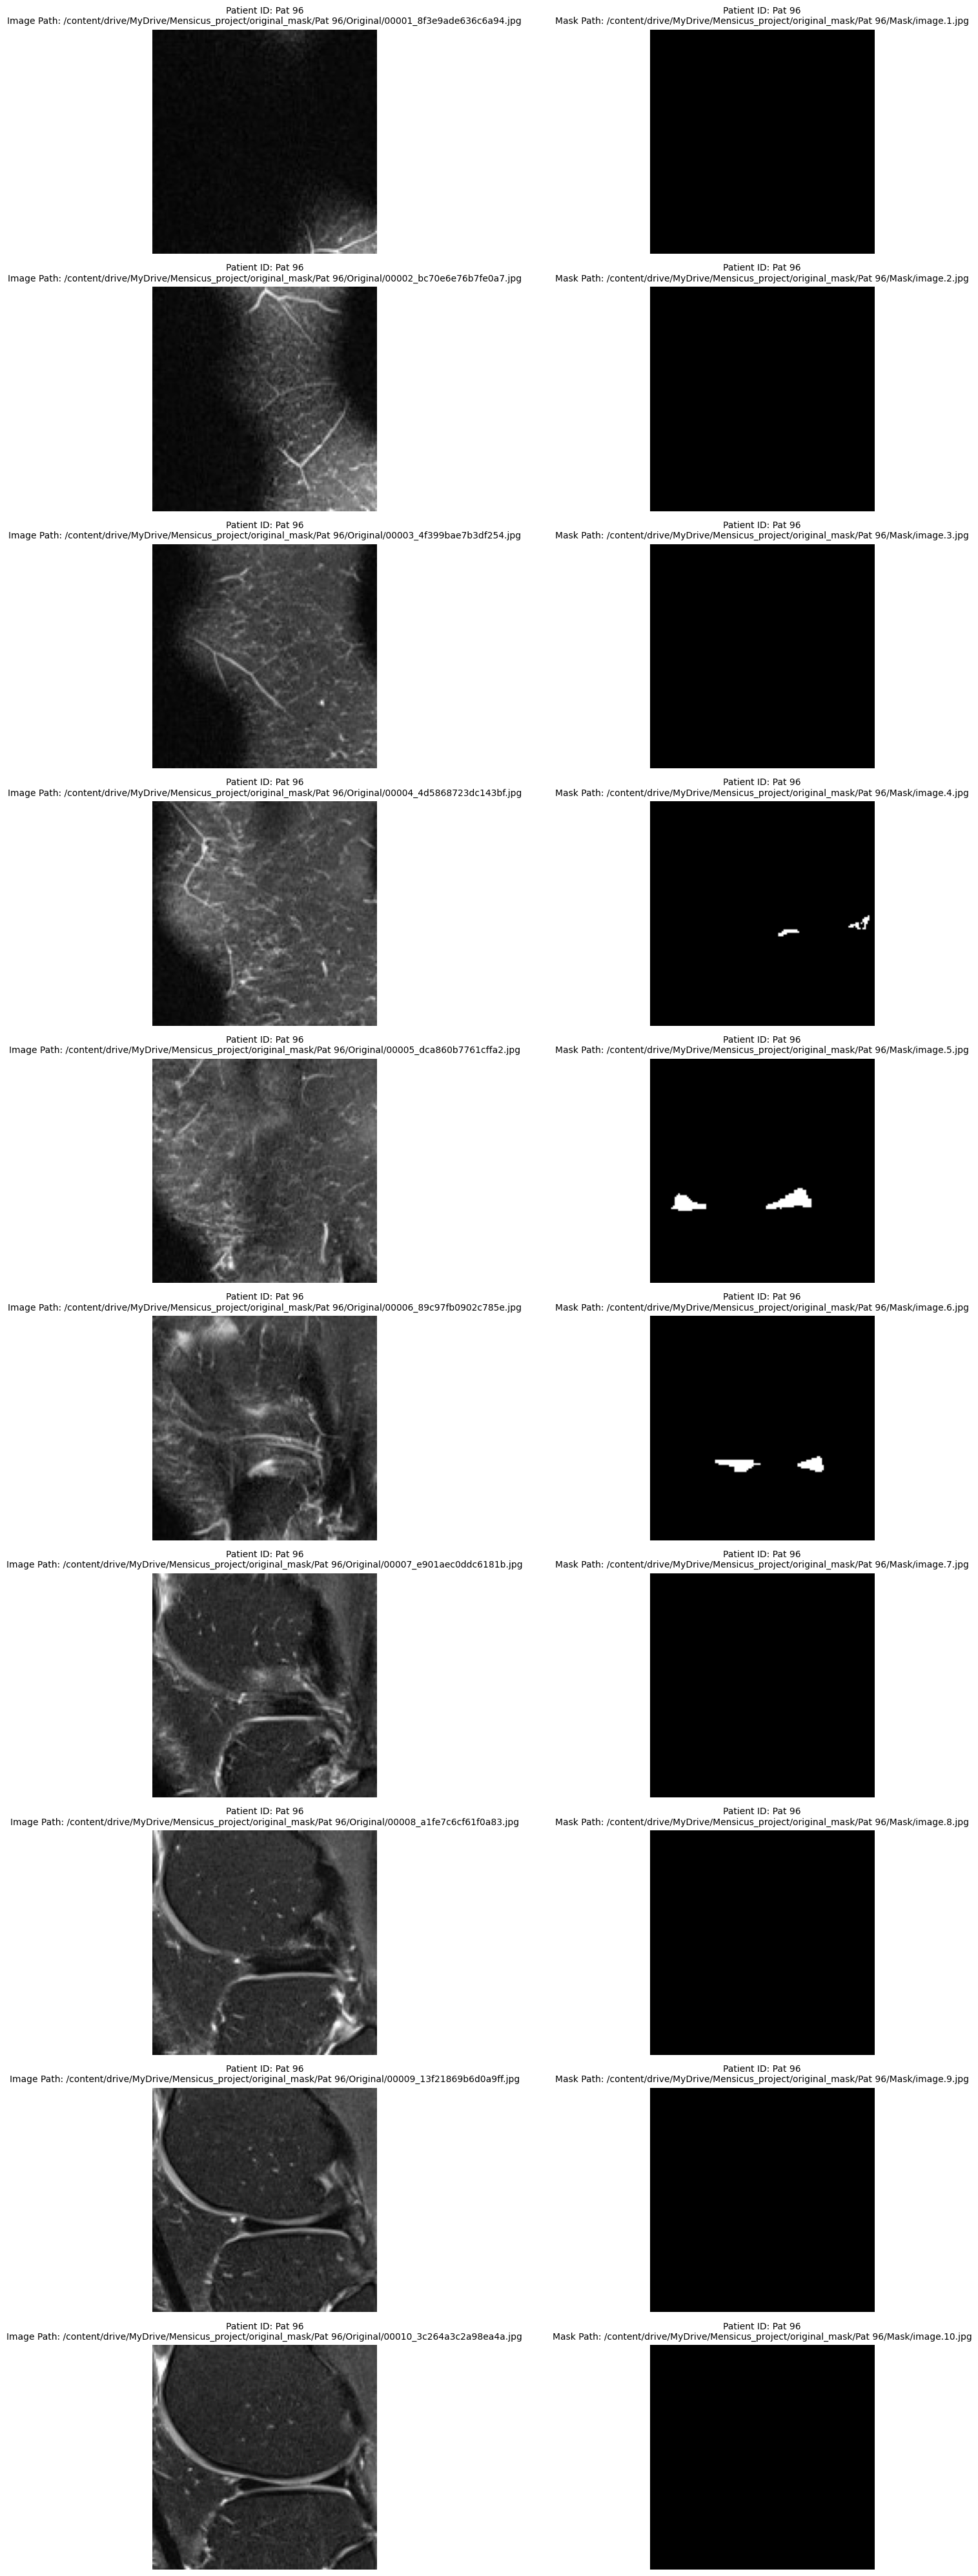

In [ ]:


def plot_images_with_paths(images, masks, image_paths, mask_paths, num_images=10):
    """
    Plot images with their corresponding file paths and patient numbers.

    Args:
        images (array): Array of images.
        masks (array): Array of masks.
        image_paths (list): List of image file paths.
        mask_paths (list): List of mask file paths.
        num_images (int): Number of images to display.
    """
    num_images = min(num_images, len(images))  # Ensure we don't exceed the available number of images
    plt.figure(figsize=(20, num_images * 4))

    for i in range(num_images):
        # Display original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Patient ID: {os.path.basename(os.path.dirname(os.path.dirname(image_paths[i])))}\n"
                  f"Image Path: {image_paths[i]}", fontsize=10)
        plt.axis('off')

        # Display mask
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f"Patient ID: {os.path.basename(os.path.dirname(os.path.dirname(mask_paths[i])))}\n"
                  f"Mask Path: {mask_paths[i]}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_images_with_paths(images, masks, image_paths, mask_paths, num_images=10)


NESTED-UNET with Attention Mechanism Model

In [ ]:

# Function to create a convolution block with Batch Normalization
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation=None, padding='same')(input_tensor)  # No activation yet
    x = BatchNormalization()(x)  # Apply BatchNormalization
    x = tf.keras.activations.relu(x)  # Apply ReLU activation
    x = Dropout(0.3)(x)  # Dropout for regularization
    x = Conv2D(num_filters, (3, 3), activation=None, padding='same')(x)  # Second convolution
    x = BatchNormalization()(x)  # Apply BatchNormalization
    x = tf.keras.activations.relu(x)  # Apply ReLU activation
    return x

# Function to create Attention Gate
def attention_gate(x, g, filters):
    """
    Attention Gate implementation using element-wise multiplication (Ref: Ozan Oktay et al. 2018).
    x: Input feature map (skip connection)
    g: Input gating signal (from the decoder)
    filters: Number of filters for the attention layer
    """
    # Convolution for gating signal g
    g1 = Conv2D(filters, (1, 1), padding='same')(g)
    g1 = BatchNormalization()(g1)
    g1 = tf.keras.activations.relu(g1)

    # Convolution for skip connection feature map x
    x1 = Conv2D(filters, (1, 1), padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.activations.relu(x1)

    # Before adding, ensure g1 has the same spatial dimensions as x1 using UpSampling2D
    g1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(g1)  # Adjust size as needed

    # Adding the gating and skip connections
    psi = tf.keras.layers.add([x1, g1])
    psi = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(psi)

    # Multiply the attention map with the input feature map
    return Multiply()([x, psi])

# Function to build the Nested U-Net with Attention Mechanism
def build_nested_unet_with_attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder with skip connections
    x1_0 = conv_block(inputs, 64)
    x2_0 = conv_block(MaxPooling2D((2, 2))(x1_0), 128)
    x3_0 = conv_block(MaxPooling2D((2, 2))(x2_0), 256)
    x4_0 = conv_block(MaxPooling2D((2, 2))(x3_0), 512)

    # Bottleneck
    x5_0 = conv_block(MaxPooling2D((2, 2))(x4_0), 1024)

    # Decoder with attention gates
    x4_1 = conv_block(concatenate([UpSampling2D((2, 2))(x5_0), Cropping2D(cropping=((0, 0), (0, 0)))(x4_0)], axis=-1), 512)
    x4_1 = attention_gate(x4_1, x5_0, 512)  # Attention Gate

    x3_2 = conv_block(concatenate([UpSampling2D((2, 2))(x4_1), Cropping2D(cropping=((0, 0), (0, 0)))(x3_0)], axis=-1), 256)
    x3_2 = attention_gate(x3_2, x4_1, 256)  # Attention Gate

    x2_3 = conv_block(concatenate([UpSampling2D((2, 2))(x3_2), Cropping2D(cropping=((0, 0), (0, 0)))(x2_0)], axis=-1), 128)
    x2_3 = attention_gate(x2_3, x3_2, 128)  # Attention Gate

    x1_4 = conv_block(concatenate([UpSampling2D((2, 2))(x2_3), Cropping2D(cropping=((0, 0), (0, 0)))(x1_0)], axis=-1), 64)
    x1_4 = attention_gate(x1_4, x2_3, 64)  # Attention Gate

    # Output layer with sigmoid activation for binary segmentation
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x1_4)

    model = Model(inputs, outputs)
    return model

# Hyperparameters
input_shape = (128, 128, 1)  # Assuming single-channel grayscale images
num_classes = 1  # Binary segmentation
learning_rate = 0.001
batch_size = 16
num_epochs = 50

# Build and compile the model
model = build_nested_unet_with_attention(input_shape, num_classes)

# Display the model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)       

 Total params: 32,456,389 (123.81 MB)

 Trainable params: 32,440,773 (123.75 MB)

 Non-trainable params: 15,616 (61.00 KB)

In [ ]:

# Define Dice Loss
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)  # Cast to float32
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Define Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)  # Cast to float32
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop if no improvement for 5 epochs
    restore_best_weights=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=dice_loss,
              metrics=['accuracy', dice_coefficient])  # Add Dice Coefficient to metrics

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8311 - dice_coefficient: 0.0290 - loss: 0.9710 - val_accuracy: 0.9449 - val_dice_coefficient: 0.0090 - val_loss: 0.9910
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.9892 - dice_coefficient: 0.1711 - loss: 0.8289 - val_accuracy: 0.9742 - val_dice_coefficient: 0.0013 - val_loss: 0.9987
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 378ms/step - accuracy: 0.9958 - dice_coefficient: 0.4461 - loss: 0.5539 - val_accuracy: 0.9964 - val_dice_coefficient: 0.1250 - val_loss: 0.8750
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step - accuracy: 0.9964 - dice_coefficient: 0.5430 - loss: 0.4570 - val_accuracy: 0.9662 - val_dice_coefficient: 0.1094 - val_loss: 0.8906
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - accuracy: 0.9967 - dice_coefficient: 0.5553 - loss: 0.4447 - val_accuracy: 0.9927 - val_dice_coefficient: 0.2206 - val_loss: 0.7791
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.

In [ ]:
model.save('/content/drive/MyDrive/Masked_DCM/nested_unet_model.h5')

In [ ]:


# Load the model, providing custom objects
model = load_model(
    '/content/drive/MyDrive/Mensicus_project/nested_unet_model.h5',
    custom_objects={
        'dice_loss': dice_loss,
        'dice_coefficient': dice_coefficient
    }
)




7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9985 - dice_coefficient: 0.7196 - loss: 0.2728
Test Loss: 0.26689907908439636
Test Accuracy: 0.9985474348068237
Test Dice Coefficient: 0.7025126218795776
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


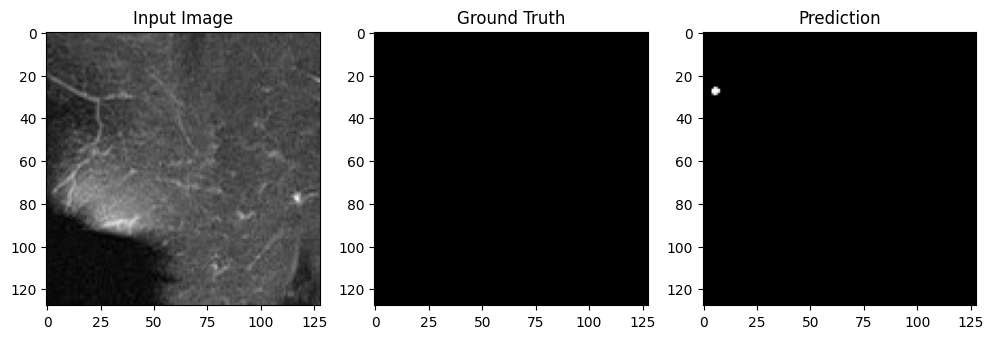

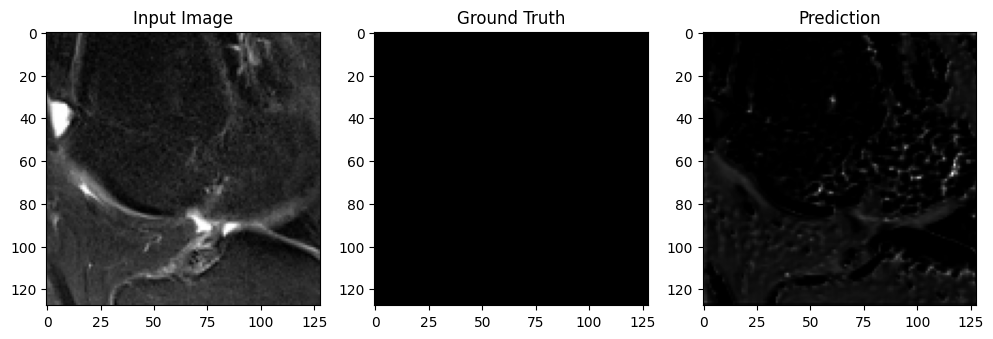

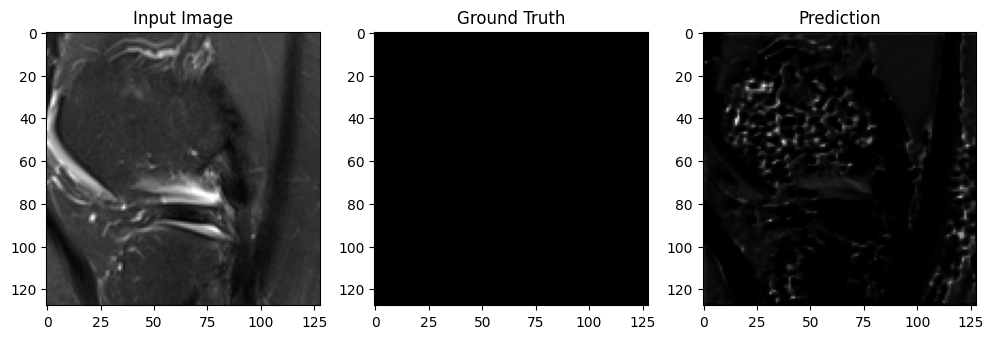

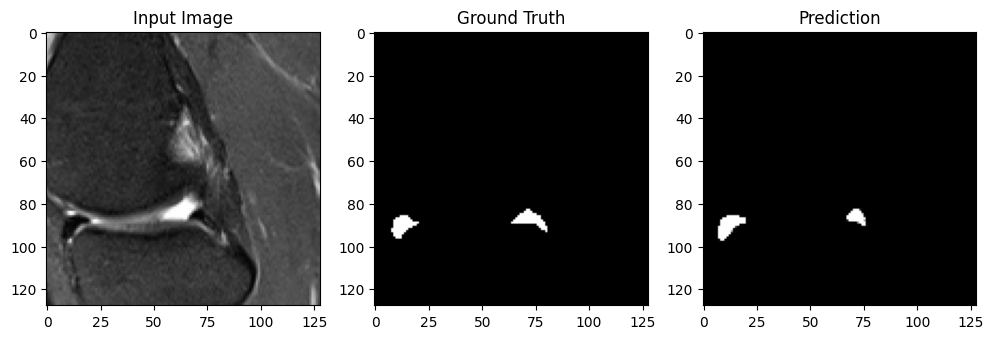

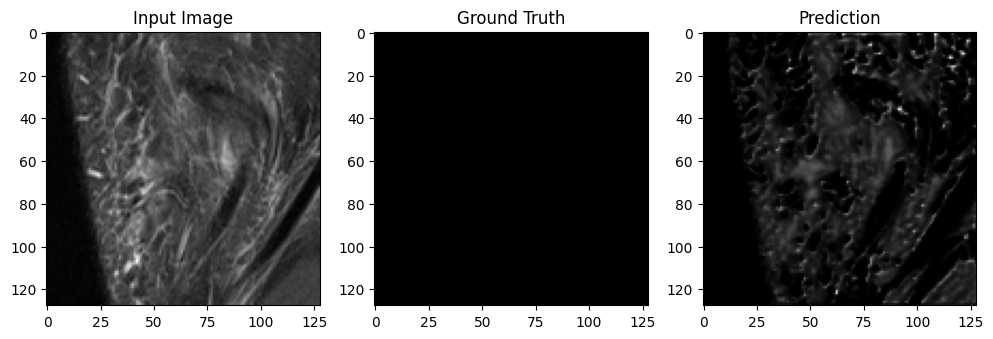

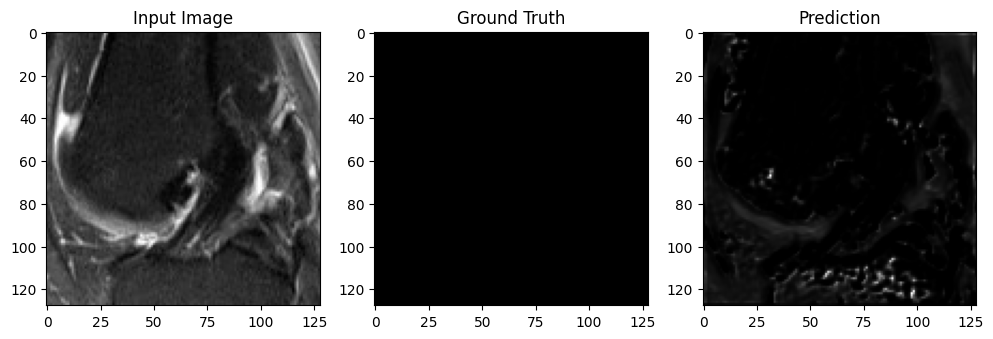

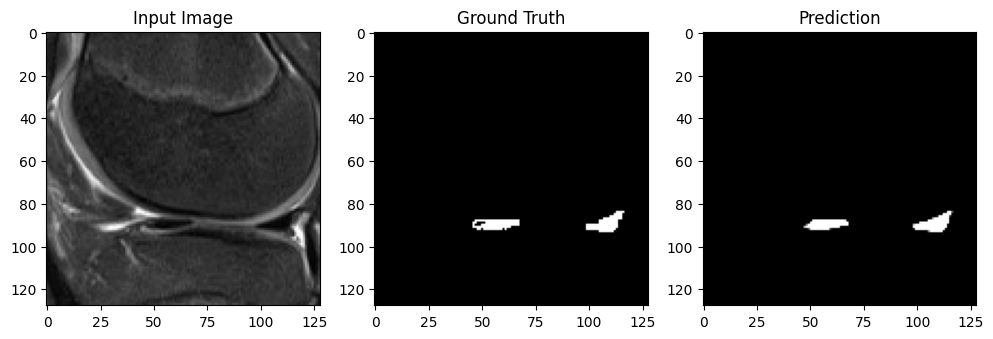

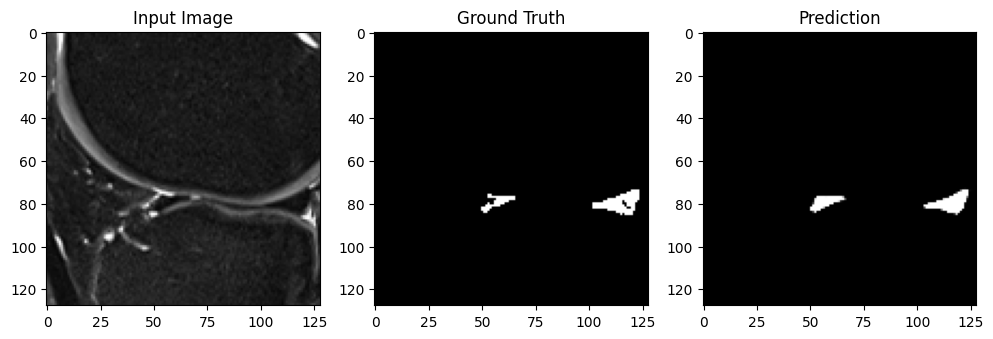

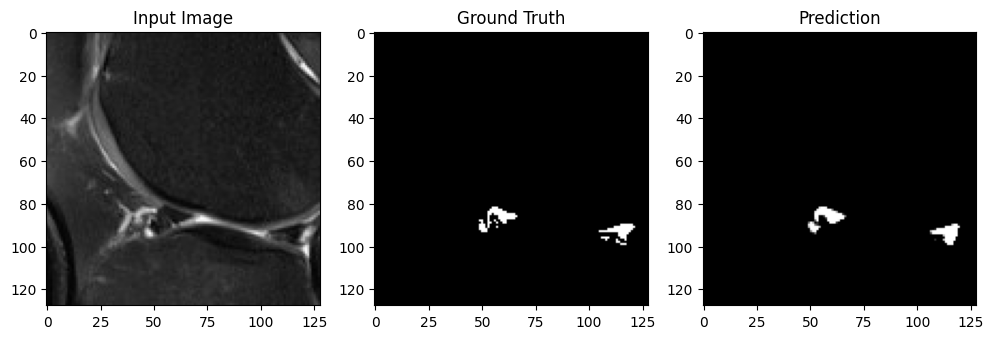

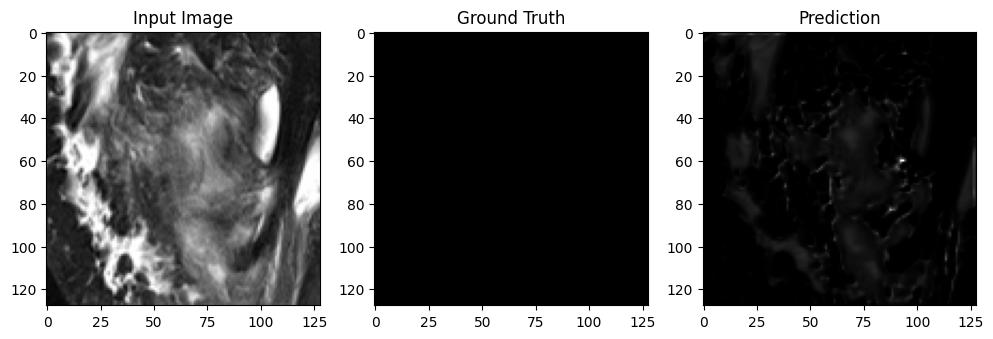

In [ ]:

loss, accuracy, dice_coef = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Dice Coefficient: {dice_coef}")

# Visualize results
def visualize_predictions(model, X, y_true, num_samples=10):
    predictions = model.predict(X[:num_samples])
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.show()

visualize_predictions(model, X_test, y_test)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Classfication

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GRU, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:


def load_and_center_crop_images(path, label, crop_height_ratio=0.7, img_size=(128, 128)):
    """
    Load images, crop the top and bottom areas, and resize to target size.

    Args:
        path (str): Path to the images.
        label (int): Label for the images.
        crop_height_ratio (float): Fraction of the height to retain (centered).
        img_size (tuple): Target size for resizing (width, height).

    Returns:
        np.ndarray: Array of cropped and resized images.
        np.ndarray: Corresponding labels.
    """
    images = []
    labels = []

    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith(('jpg', 'png')):
                full_path = os.path.join(dirname, filename)

                # Open the image and preprocess
                image = Image.open(full_path).convert('L')  # Convert to grayscale
                image = np.array(image)
                h, w = image.shape  # Original dimensions

                # Determine crop boundaries (focus on the center height)
                crop_height = int(h * crop_height_ratio)
                y_start = (h - crop_height) // 2
                y_end = y_start + crop_height

                cropped_image = image[y_start:y_end, :]  # Crop top and bottom, retain full width

                # Resize to target size and normalize
                resized_image = Image.fromarray(cropped_image).resize(img_size)
                normalized_image = np.array(resized_image) / 255.0

                images.append(normalized_image)
                labels.append(label)

    return np.array(images), np.array(labels)


In [ ]:
# Load datasets
non_teared_images, non_teared_labels = load_and_center_crop_images('/content/drive/MyDrive/Mensicus_project/Non-teared_data', label=0)
teared_images, teared_labels = load_and_center_crop_images('/content/drive/MyDrive/Mensicus_project/Teared_data', label=1)

# Combine and shuffle datasets
images = np.concatenate([non_teared_images, teared_images], axis=0)
labels = np.concatenate([non_teared_labels, teared_labels], axis=0)

# Shuffle the dataset
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Reshape images for CNN input (add channel dimension)
images = images[..., np.newaxis]  # Add channel dimension for grayscale images

# # Split dataset into training and testing

X_train, X_val, y_train, y_val= train_test_split(images, labels, test_size=0.2, random_state=42)




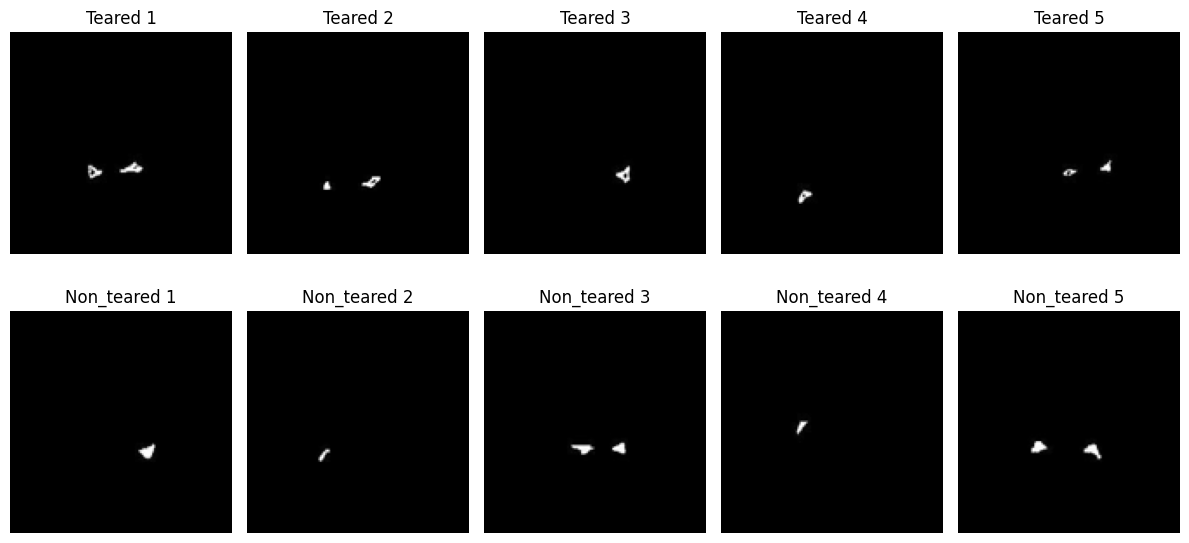

In [ ]:
# Plot function remains unchanged
def plot_images(teared_images, non_teared_images, num_images=5):
    teared_samples = random.sample(list(teared_images), num_images)
    non_teared_samples = random.sample(list(non_teared_images), num_images)

    fig, axes = plt.subplots(2, num_images, figsize=(12, 6))

    for i in range(num_images):
        ax = axes[0, i]
        ax.imshow(teared_samples[i].squeeze(), cmap='gray')  # Adjust for grayscale
        ax.set_title(f"Teared {i+1}")
        ax.axis('off')

    for i in range(num_images):
        ax = axes[1, i]
        ax.imshow(non_teared_samples[i].squeeze(), cmap='gray')  # Adjust for grayscale
        ax.set_title(f"Non_teared {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example plot (optional to verify images)
plot_images(teared_images, non_teared_images, num_images=5)

CNN-GRU Model

In [ ]:
# Define the CNN-GRU model
def create_cnn_gru_model(input_shape):
    model = Sequential([
        # CNN Layers
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten and Reshape for GRU input
        Flatten(),
        Reshape((1, -1)),  # Reshape to (timesteps, features)

        # GRU Layer
        GRU(64, return_sequences=False, activation='relu'),
        Dropout(0.25),

        # Fully Connected Layer
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model



In [ ]:
# Compile the model
input_shape = X_train.shape[1:]  # e.g., (128, 128, 1)
model = create_cnn_gru_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 57600)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │      11,071,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,094,913 (42.32 MB)

 Trainable params: 11,094,913 (42.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)

history = model.fit(
    X_train, y_train,
    epochs=50,               # Maximum number of epochs
    batch_size=4,
    validation_data=(X_val, y_val),  # Pass validation data directly
    callbacks=[early_stopping]  # Include the early stopping callback
)




Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.4909 - loss: 0.7022 - val_accuracy: 0.5690 - val_loss: 0.6908
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5741 - loss: 0.6853 - val_accuracy: 0.7069 - val_loss: 0.6395
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6190 - loss: 0.6324 - val_accuracy: 0.6897 - val_loss: 0.5951
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6512 - loss: 0.5257 - val_accuracy: 0.6897 - val_loss: 0.5437
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8175 - loss: 0.4427 - val_accuracy: 0.7414 - val_loss: 0.4934
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8156 - loss: 0.4745 - val_accuracy: 0.7586 - val_loss: 0.4848
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8116 - loss: 0.3546 - val_accuracy: 0.8276 - val_loss: 0.4553
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8735 - loss: 0.3329 - val_accuracy: 0.8793 - val

In [ ]:
# Save the trained model to a file
model.save('/content/drive/MyDrive/Masked_DCM/teared_nonteared_model.h5')# Save the model in HDF5 format
print("Model saved successfully.")


Model saved successfully.


In [ ]:


# Load the saved model
model = load_model('/content/drive/MyDrive/Mensicus_project/teared_nonteared_model.h5')
print("Model loaded successfully.")


Model loaded successfully.


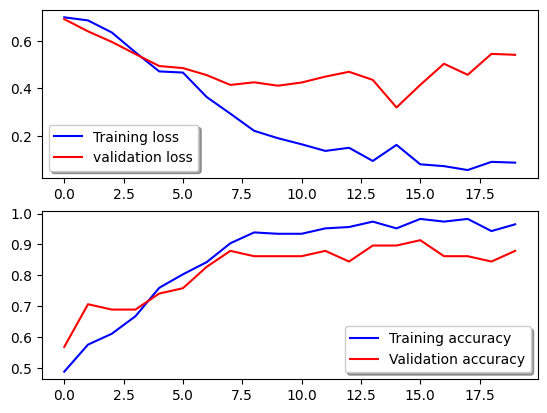

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes (0 or 1)

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=['Non-Teared', 'Teared']))



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 865ms/step
Classification Report:
              precision    recall  f1-score   support

  Non-Teared       0.93      1.00      0.97        28
      Teared       1.00      0.93      0.97        30

    accuracy                           0.97        58
   macro avg       0.97      0.97      0.97        58
weighted avg       0.97      0.97      0.97        58



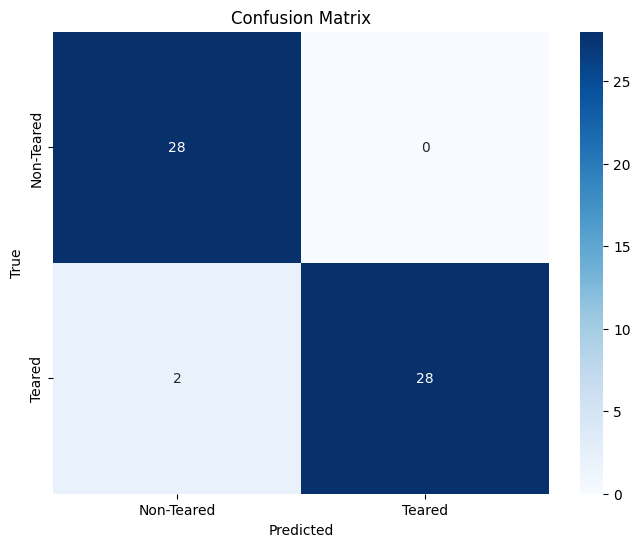

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Teared', 'Teared'], yticklabels=['Non-Teared', 'Teared'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1: True Label: Non-Teared, Predicted Label: Non-Teared
Image 2: True Label: Non-Teared, Predicted Label: Non-Teared
Image 3: True Label: Non-Teared, Predicted Label: Non-Teared
Image 4: True Label: Teared, Predicted Label: Teared
Image 5: True Label: Non-Teared, Predicted Label: Non-Teared
Image 6: True Label: Teared, Predicted Label: Teared
Image 7: True Label: Non-Teared, Predicted Label: Non-Teared
Image 8: True Label: Teared, Predicted Label: Teared
Image 9: True Label: Teared, Predicted Label: Teared
Image 10: True Label: Non-Teared, Predicted Label: Non-Teared


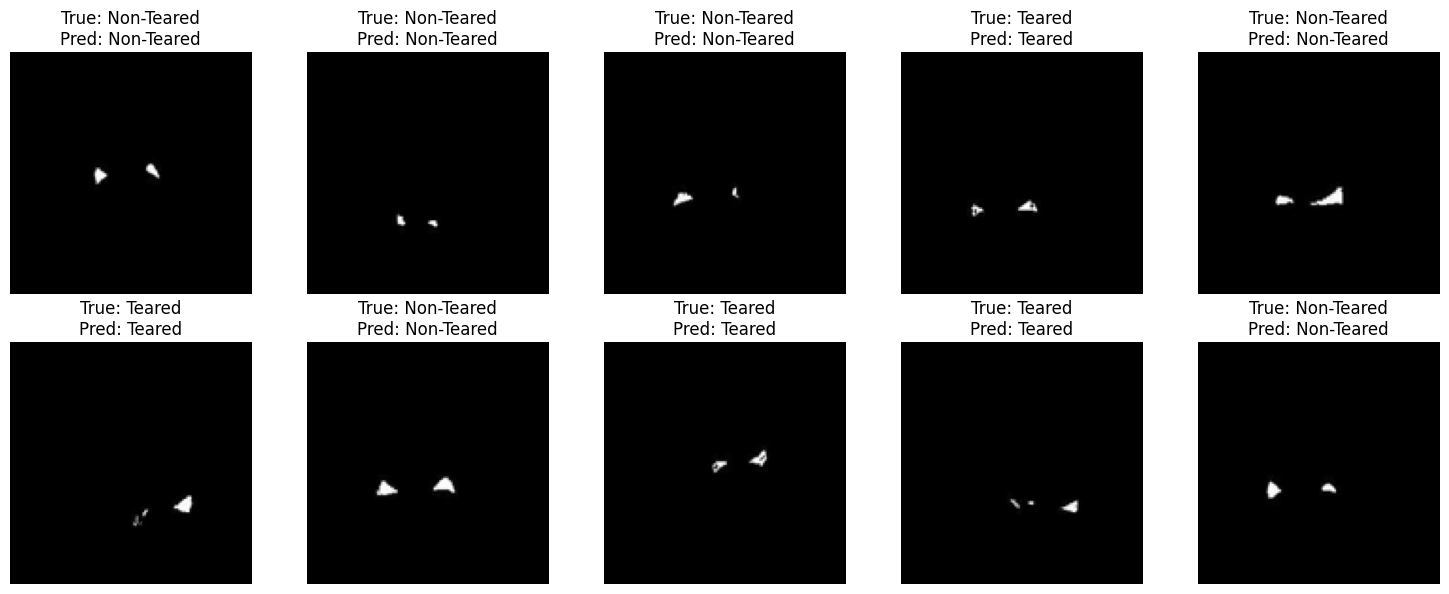

In [ ]:


# Assuming X_test_gray is already created and is in grayscale (shape: [num_images, height, width, 1])

# Select 10 random images from the test dataset
num_images = 10
indices = np.random.choice(X_val.shape[0], num_images, replace=False)  # Random indices
sample_images = X_val[indices]  # Select grayscale images
sample_labels = y_val[indices]  # True labels for comparison

# Make predictions
predictions = model.predict(sample_images)

# Interpret predictions
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Print results
for i in range(num_images):
    true_label = "Teared" if sample_labels[i] == 1 else "Non-Teared"
    predicted_label = "Teared" if predicted_classes[i] == 1 else "Non-Teared"
    print(f"Image {i+1}: True Label: {true_label}, Predicted Label: {predicted_label}")

# Plot the grayscale images with true and predicted labels
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')  # Display the image in grayscale
    true_label = "Teared" if sample_labels[i] == 1 else "Non-Teared"
    predicted_label = "Teared" if predicted_classes[i] == 1 else "Non-Teared"
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()
